In [2]:
from torch_geometric.data import Data
import torch
import numpy as np
from torch_geometric.datasets import KarateClub, Planetoid
import torch_geometric
from torch_geometric.utils import subgraph
from utils import *

### Previous Work by Shubhajit Roy

In [63]:
edge_index = torch.tensor([[3,5,6,2,4],[5,3,2,6,6]],dtype=torch.long)
x = torch.tensor([[1,2,3],[4,5,6],[7,8,9],[10,11,12],[13,14,15],[1,33,4],[12, 4, 2]],dtype=torch.float)
y = torch.tensor([0,1,0,1,0,0,1],dtype=torch.long)
data = Data(x=x,edge_index=edge_index,y=y)

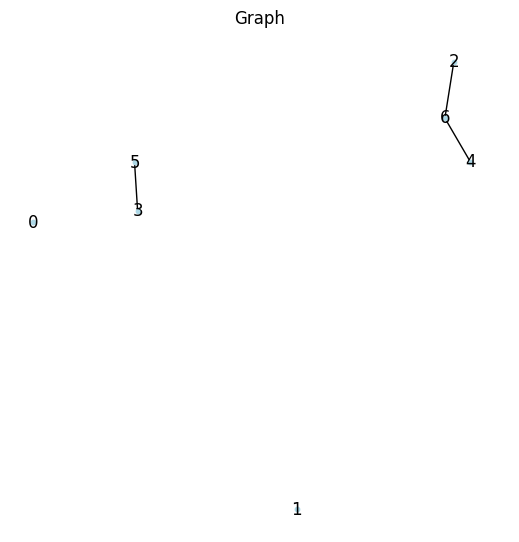

In [27]:
#convert graph to networkx
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

#convert to networkx with node attributes
G = to_networkx(data, to_undirected=True)
#plot
plt.figure(figsize=(5,5))
pos = nx.spring_layout(G)
nx.draw(G,pos,node_size=10,node_color='lightblue',with_labels=True)
plt.title('Graph')
plt.show()


In [13]:
from torch_geometric.utils import *

H = subgraph(edge_index=data.edge_index, subset=[[1,2,4,6]], relabel_nodes=False)

In [14]:
data.edge_index

tensor([[3, 5, 6, 2, 4],
        [5, 3, 2, 6, 6]])

In [15]:
H

(tensor([[6, 2, 4],
         [2, 6, 6]]),
 None)

In [16]:
data.x

tensor([[ 1.,  2.,  3.],
        [ 4.,  5.,  6.],
        [ 7.,  8.,  9.],
        [10., 11., 12.],
        [13., 14., 15.],
        [ 1., 33.,  4.],
        [12.,  4.,  2.]])

In [17]:
#create a new x tensor with node 1,2,4,6
data.x[[1,2,4,6]]


tensor([[ 4.,  5.,  6.],
        [ 7.,  8.,  9.],
        [13., 14., 15.],
        [12.,  4.,  2.]])

In [18]:
list_of_nodes = [1,2,4,6]
#convert to numpy ndarray
import numpy as np
list_of_nodes = np.array(list_of_nodes)

In [19]:
coarsen_node = 6

In [20]:
list_of_nodes+coarsen_node

array([ 7,  8, 10, 12])

In [21]:
subgraph_edge_index = subgraph(edge_index=data.edge_index, subset=torch.tensor(list_of_nodes), relabel_nodes=True)

In [22]:
M = Data(x=data.x[list_of_nodes],edge_index=subgraph_edge_index[0], y=data.y[list_of_nodes], mapping={int(value): i for i, value in enumerate(list_of_nodes)})

In [23]:
M.num_nodes

4

In [24]:
M.edge_index, M.mapping

(tensor([[3, 1, 2],
         [1, 3, 3]]),
 {1: 0, 2: 1, 4: 2, 6: 3})

In [25]:
for key, value in M.mapping.items():
    print(key, value)

1 0
2 1
4 2
6 3


In [1]:
import torch
A = torch.rand(0,7)
A.shape, A

(torch.Size([0, 7]), tensor([], size=(0, 7)))

### Train Val Test Split for Original Graph (Custom Function to split data, *Using Older Coarsening Function*)

In [4]:
def split_data(graph: Data, train_size: float, val_size: float, seed: float = 42):
    """
    Function that returns the train, validation and test graphs for a given input graph.
    
    Parameters
    ---
    graph: torch_geometric.data.Data
        `torch_geometric.data.Data` type graph with node-feature matrix `x`, `edge_index` and labels `y`
    
    train_size: float
        Portion of the entire graph reserved for training.

    val_size: float
        Portion of the training graph reserved for validation.
    
    seed: float
        Random seed for reproducibility of results.

    Returns
    ---
    (`train_subgraph`, `val_subgraph`, `test_subgraph`):
        Desired subgraphs with corresponding `x`, `edge_index`, `y` and `orig_nodes`. Additionally, a `mapping` dictionary {relabeled_node: orig_node} is added.

    NOTE
    ---
    `edge_index` is composed of `orig_nodes` and NOT relabeled_node
    """
    np.random.seed(seed)
    unique_nodes = set(graph.edge_index[0].numpy())
    shuffled_unique_nodes = np.random.choice(list(unique_nodes), size = len(unique_nodes), replace = False)
    train_nodes = shuffled_unique_nodes[:int(len(unique_nodes)*(train_size*(1-val_size)))]
    val_nodes = shuffled_unique_nodes[int(len(unique_nodes)*(train_size*(1-val_size))):int(len(unique_nodes)*(train_size))]
    test_nodes = shuffled_unique_nodes[int(len(unique_nodes)*(train_size)):]
    # print(unique_nodes)
    # print(torch.tensor(train_nodes), torch.tensor(val_nodes), torch.tensor(test_nodes))
    
    train_edge_index = subgraph(subset = torch.tensor(train_nodes), edge_index = graph.edge_index)[0] # relabel_nodes = False
    val_edge_index = subgraph(subset = torch.tensor(val_nodes), edge_index = graph.edge_index)[0] # relabel_nodes = False
    test_edge_index = subgraph(subset = torch.tensor(test_nodes), edge_index = graph.edge_index)[0] # relabel_nodes = False

    train_subgraph = Data(x = graph.x[train_nodes], edge_index = train_edge_index, y = graph.y[train_nodes], orig_nodes = torch.tensor(train_nodes)) # mapping={i:value for i, value in enumerate(train_nodes)}
    val_subgraph = Data(x = graph.x[val_nodes], edge_index = val_edge_index, y = graph.y[val_nodes], orig_nodes = torch.tensor(val_nodes)) #  mapping={i:value for i, value in enumerate(val_nodes)}
    test_subgraph = Data(x = graph.x[test_nodes], edge_index = test_edge_index, y = graph.y[test_nodes], orig_nodes = torch.tensor(test_nodes)) # , mapping={i:value for i, value in enumerate(test_nodes)}

    return (train_subgraph, val_subgraph, test_subgraph)

In [3]:
dataset = Planetoid("./dataset", name="cora")
data = dataset[0]
train, val, test = split_data(data, 0.8, 0.3)

In [4]:
len(train.x), len(val.x), len(test.x)

(1516, 650, 542)

Independently coarsening each of the tran, val and test sets (`COARSENING RATIO` = 0.7 AND `COARSENING METHODS` = "Variation Neighborhoods" ARE SAME ACCROSS ALL THE SETS)

In [5]:
# For Training Set
train_num_features, train_num_classes, train_candidate, train_C_list, train_Gc_list, train_map_list = coarsening(dataset='test.ipynb', coarsening_ratio=0.7, coarsening_method="variation_neighborhoods", Dataset=train)
# For Validation Set
val_num_features, val_num_classes, val_candidate, val_C_list, val_Gc_list, val_map_list = coarsening(dataset='test.ipynb', coarsening_ratio=0.7, coarsening_method="variation_neighborhoods", Dataset=val)
# For Testing  Set
test_num_features, test_num_classes, test_candidate, test_C_list, test_Gc_list, test_map_list = coarsening(dataset='test.ipynb', coarsening_ratio=0.7, coarsening_method="variation_neighborhoods", Dataset=test)

Data Verfication: Data(x=[1516, 1433], edge_index=[2, 3244], y=[1516], orig_nodes=[1516])


f:\D\Python\IITGN\Graph Coarsening - Summer of GNN\CoPart-GNN\graph_coarsening\coarsening_utils.py:102: RuntimeWarning: invalid value encountered in power
  dinvsqrt = d ** (-1 / 2)
f:\D\Python\.venv\Lib\site-packages\scipy\sparse\linalg\_eigen\arpack\arpack.py:1600: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "


Data Verfication: Data(x=[650, 1433], edge_index=[2, 638], y=[650], orig_nodes=[650])
Data Verfication: Data(x=[542, 1433], edge_index=[2, 394], y=[542], orig_nodes=[542])


In [6]:
print(f'''
    -----------------------------
    Num of Features accross sets:
    Train:  {train_num_features}
    Val:    {val_num_features}
    Test:   {test_num_features}
    -----------------------------
    Num of classes accross sets:
    Train:  {train_num_classes}
    Val:    {val_num_classes}
    Test:   {test_num_classes}
    -----------------------------
    Num of disconnected components accross sets:
    Train:  {len(train_map_list)} or {len(train_candidate)}
    Val:    {len(val_map_list)}   or {len(val_candidate)}
    Test:   {len(test_map_list)}  or {len(test_candidate)}
    -----------------------------
    Num of nodes in original sets v/s metanodes in coarsened set:
    Train:  {len(train.x)}  v/s {sum([len(component.keys()) for component in train_map_list])}
    Val:    {len(val.x)}    v/s {sum([len(component.keys()) for component in val_map_list])}    
    Test:   {len(test.x)}   v/s {sum([len(component.keys()) for component in test_map_list])}
    ''')


    -----------------------------
    Num of Features accross sets:
    Train:  1433
    Val:    1433
    Test:   1433
    -----------------------------
    Num of classes accross sets:
    Train:  7
    Val:    7
    Test:   7
    -----------------------------
    Num of disconnected components accross sets:
    Train:  1066 or 1066
    Val:    635   or 635
    Test:   539  or 539
    -----------------------------
    Num of nodes in original sets v/s metanodes in coarsened set:
    Train:  1516  v/s 1288
    Val:    650    v/s 650    
    Test:   542   v/s 542
    


↑↑↑↑↑ COMMENT ↑↑↑↑↑ <br>
NO COARSENING OCCURRED IN `val` and `test` sets because all the nodes nodes are completely disconnected (for the particular random seed)

Normal Use (`COARSENING RATIO` = 0.7 and `COARSENING METHOD` = Variation Neighborhoods)

In [7]:
num_features, num_classes, candidate, C_list, Gc_list, map_list = coarsening(dataset = "cora", coarsening_ratio=0.7, coarsening_method="variation_neighborhoods", Dataset=None)

Data Verfication: Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [9]:
print(f'''
    -----------------------------
    Num of Features accross sets:   {num_features}
    -----------------------------
    Num of classes accross sets:    {num_classes}
    -----------------------------
    Num of disconnected components accross sets:    {len(candidate)} or {len(map_list)}
    -----------------------------
    Num of nodes in original sets v/s metanodes in coarsened set: {len(Planetoid("./dataset", 'cora')[0].x)} v/s {sum([len(component.keys()) for component in map_list])}
    ''')


    -----------------------------
    Num of Features accross sets:   1433
    -----------------------------
    Num of classes accross sets:    7
    -----------------------------
    Num of disconnected components accross sets:    78 or 78
    -----------------------------
    Num of nodes in original sets v/s metanodes in coarsened set: 2708 v/s 927
    


Verification

In [16]:
nodes = []
for idx, component in enumerate(test_map_list): # Vary the obtained map_list: `train_map_list`, `val_map_list`, `test_map_list`
    # print(f"{idx} -> {len(component.keys())}")
    for k,v in component.items():
        nodes.extend(v)
print(f"Number of original nodes in the set: {len(set(nodes))}")

Number of original nodes in the set: 542


### Train Val Test Split for Original Graph (Custome Function to split data, *Using New Coarsening Function*)

In [3]:
def split_data(graph: Data, train_size: float, val_size: float, seed: float = 42):
    """
    Function that returns the train, validation and test graphs for a given input graph.
    
    Parameters
    ---
    graph: torch_geometric.data.Data
        `torch_geometric.data.Data` type graph with node-feature matrix `x`, `edge_index` and labels `y`
    
    train_size: float
        Portion of the entire graph reserved for training.

    val_size: float
        Portion of the training graph reserved for validation.
    
    seed: float
        Random seed for reproducibility of results.

    Returns
    ---
    (`train_subgraph`, `val_subgraph`, `test_subgraph`):
        Desired subgraphs with corresponding `x`, `edge_index`, `y` and `orig_nodes`. Additionally, a `mapping` dictionary {relabeled_node: orig_node} is added.

    NOTE
    ---
    `edge_index` is composed of `orig_nodes` and NOT relabeled_node
    """
    np.random.seed(seed)
    unique_nodes = set(graph.edge_index[0].numpy())
    shuffled_unique_nodes = np.random.choice(list(unique_nodes), size = len(unique_nodes), replace = False)
    train_nodes = shuffled_unique_nodes[:int(len(unique_nodes)*(train_size*(1-val_size)))]
    val_nodes = shuffled_unique_nodes[int(len(unique_nodes)*(train_size*(1-val_size))):int(len(unique_nodes)*(train_size))]
    test_nodes = shuffled_unique_nodes[int(len(unique_nodes)*(train_size)):]
    # print(unique_nodes)
    # print(torch.tensor(train_nodes), torch.tensor(val_nodes), torch.tensor(test_nodes))
    
    train_edge_index = subgraph(subset = torch.tensor(train_nodes), edge_index = graph.edge_index)[0] # relabel_nodes = False
    val_edge_index = subgraph(subset = torch.tensor(val_nodes), edge_index = graph.edge_index)[0] # relabel_nodes = False
    test_edge_index = subgraph(subset = torch.tensor(test_nodes), edge_index = graph.edge_index)[0] # relabel_nodes = False

    train_subgraph = Data(x = graph.x[train_nodes], edge_index = train_edge_index, y = graph.y[train_nodes], orig_nodes = torch.tensor(train_nodes)) # mapping={i:value for i, value in enumerate(train_nodes)}
    val_subgraph = Data(x = graph.x[val_nodes], edge_index = val_edge_index, y = graph.y[val_nodes], orig_nodes = torch.tensor(val_nodes)) #  mapping={i:value for i, value in enumerate(val_nodes)}
    test_subgraph = Data(x = graph.x[test_nodes], edge_index = test_edge_index, y = graph.y[test_nodes], orig_nodes = torch.tensor(test_nodes)) # , mapping={i:value for i, value in enumerate(test_nodes)}

    return (train_subgraph, val_subgraph, test_subgraph)

In [4]:
dataset = Planetoid("./dataset", name="cora")
data = dataset[0]
train, val, test = split_data(data, 0.8, 0.3)

In [5]:
len(train.x), len(val.x), len(test.x)

(1516, 650, 542)

Independently coarsening each of the tran, val and test sets (`COARSENING RATIO` = 0.7 AND `COARSENING METHODS` = "Variation Neighborhoods" ARE SAME ACCROSS ALL THE SETS)

In [6]:
# For Training Set
train_num_features, train_num_classes, train_candidate, train_C_list, train_Gc_list, train_subgraph_list = coarsening(args, dataset='test.ipynb', coarsening_ratio=0.7, coarsening_method="variation_neighborhoods", Dataset=train)
# For Validation Set
val_num_features, val_num_classes, val_candidate, val_C_list, val_Gc_list, val_subgraph_list = coarsening(args, dataset='test.ipynb', coarsening_ratio=0.7, coarsening_method="variation_neighborhoods", Dataset=val)
# For Testing  Set
test_num_features, test_num_classes, test_candidate, test_C_list, test_Gc_list, test_subgraph_list = coarsening(args, dataset='test.ipynb', coarsening_ratio=0.7, coarsening_method="variation_neighborhoods", Dataset=test)

TypeError: coarsening() missing 1 required positional argument: 'args'

In [ ]:
print(f'''
    -----------------------------
    Num of Features accross sets:
    Train:  {train_num_features}
    Val:    {val_num_features}
    Test:   {test_num_features}
    -----------------------------
    Num of classes accross sets:
    Train:  {train_num_classes}
    Val:    {val_num_classes}
    Test:   {test_num_classes}
    -----------------------------
    Num of disconnected components accross sets:
    Train:  {len(train_subgraph_list)} or {len(train_candidate)}
    Val:    {len(val_subgraph_list)}   or {len(val_candidate)}
    Test:   {len(test_subgraph_list)}  or {len(test_candidate)}
    -----------------------------
    Num of nodes in original sets v/s metanodes in coarsened set:
    Train:  {len(train.x)}  v/s {sum([len(component.keys()) for component in train_subgraph_list])}
    Val:    {len(val.x)}    v/s {sum([len(component.keys()) for component in val_subgraph_list])}    
    Test:   {len(test.x)}   v/s {sum([len(component.keys()) for component in test_subgraph_list])}
    ''')

↑↑↑↑↑ COMMENT ↑↑↑↑↑ <br>
NOT DONE YET

Normal Use (`COARSENING RATIO` = 0.7 and `COARSENING METHOD` = Variation Neighborhoods)

In [ ]:
num_features, num_classes, candidate, C_list, Gc_list, subgraph_list = coarsening(dataset = "cora", coarsening_ratio=0.7, coarsening_method="variation_neighborhoods", Dataset=None)

In [ ]:
print(f'''
    -----------------------------
    Num of Features accross sets:   {num_features}
    -----------------------------
    Num of classes accross sets:    {num_classes}
    -----------------------------
    Num of disconnected components accross sets:    {len(candidate)} or {len(subgraph_list)}
    -----------------------------
    Num of nodes in original sets v/s metanodes in coarsened set: {len(Planetoid("./dataset", 'cora')[0].x)} v/s {sum([len(component.keys()) for component in subgraph_list])}
    ''')

Verification

In [ ]:
nodes = []
for idx, component in enumerate(test_subgraph_list): # Vary the obtained subgraph_list: `train_subgraph_list`, `val_subgraph_list`, `test_subgraph_list`
    # print(f"{idx} -> {len(component.keys())}")
    for k,v in component.items():
        nodes.extend(v)
print(f"Number of original nodes in the set: {len(set(nodes))}")

## BEWARE: The Networkx plotter is behaving unintuitively (will be explained when we meet). However, the graph data objects are right.

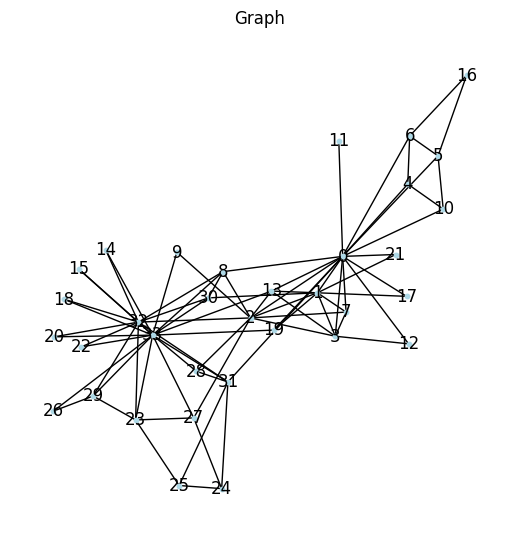

In [128]:
#convert graph to networkx
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

#convert to networkx with node attributes
G = to_networkx(data, to_undirected=True)
#plot
plt.figure(figsize=(5,5))
pos = nx.spring_layout(G)
nx.draw(G,pos,node_size=10,node_color='lightblue',with_labels=True)
plt.title('Graph')
plt.show()


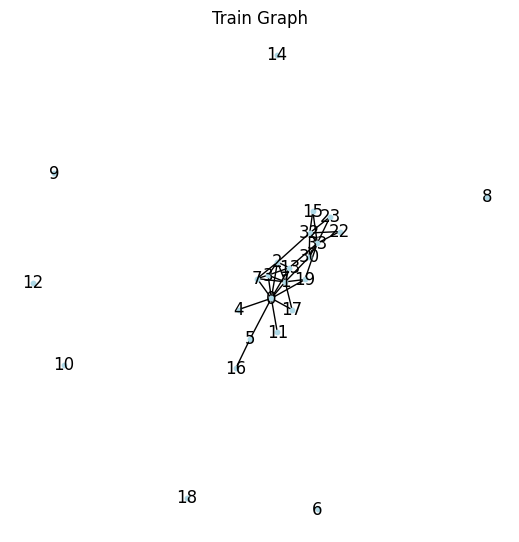

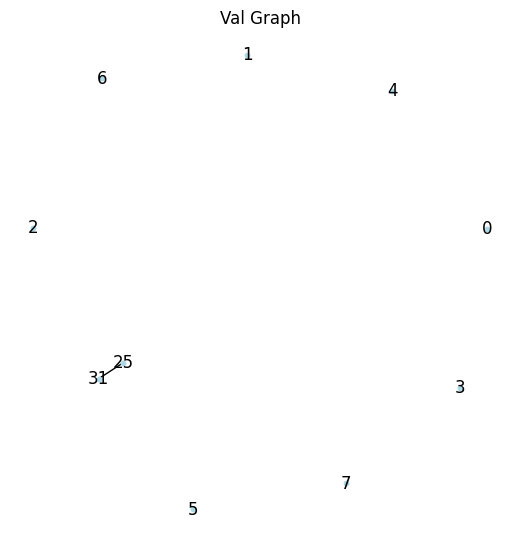

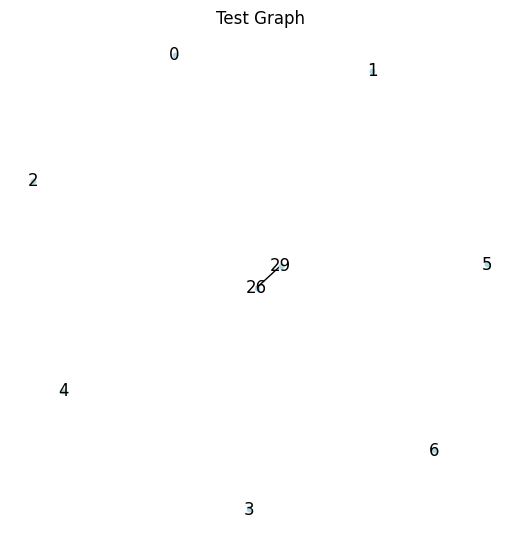

In [132]:
G = to_networkx(train, to_undirected=True)
plt.figure(figsize=(5,5))
pos = nx.spring_layout(G)
nx.draw(G,pos,node_size=10, node_color='lightblue',with_labels=True)
plt.title('Train Graph')
plt.show()

G = to_networkx(val, to_undirected=True)
plt.figure(figsize=(5,5))
pos = nx.spring_layout(G)
nx.draw(G,pos,node_size=10,node_color='lightblue',with_labels=True)
plt.title('Val Graph')
plt.show()

G = to_networkx(test, to_undirected=True)
plt.figure(figsize=(5,5))
pos = nx.spring_layout(G)
nx.draw(G,pos,node_size=10,node_color='lightblue',with_labels=True)
plt.title('Test Graph')
plt.show()